# These are the scores from fifty-three otherwise identical runs in which only the <span style="color:red">learning rate</span> is varied.

In [1]:
from pandas import read_csv

scores = read_csv('runs.csv', sep='\t')
scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 14 columns):
job         119 non-null int64
seqlen      119 non-null int64
epochs      119 non-null int64
lrate       119 non-null float64
times       119 non-null object
f_in        119 non-null object
f_out       119 non-null object
embsize     119 non-null int64
n_heads     119 non-null int64
n_enc       119 non-null int64
n_dec       119 non-null int64
network     119 non-null object
complete    119 non-null float64
distinct    119 non-null object
dtypes: float64(2), int64(7), object(5)
memory usage: 13.1+ KB


In [2]:
scores

,job,seqlen,epochs,lrate,times,f_in,f_out,embsize,n_heads,n_enc,n_dec,network,complete,distinct
0,1192,4,14,0.000198,"(""18:47:56"", ""21:35:10"")",t-in_voc,t-out,512,8,3,3,transformer,0.718206,"[0.9414924489865595, 0.9471941185173383, 0.946..."
1,1344,4,14,0.000008,"(""17:23:41"", ""20:10:02"")",t-in_voc,t-out,512,8,3,3,transformer,0.382103,"[0.7952975452093457, 0.7879684530380453, 0.782..."
2,1345,4,14,0.000010,"(""17:23:42"", ""20:09:12"")",t-in_voc,t-out,512,8,3,3,transformer,0.430072,"[0.8177628059952884, 0.8167271734058655, 0.813..."
3,1346,4,14,0.000012,"(""17:23:47"", ""20:12:51"")",t-in_voc,t-out,512,8,3,3,transformer,0.480556,"[0.842834219121647, 0.8435284343738975, 0.8417..."
4,1347,4,14,0.000016,"(""17:30:19"", ""20:16:39"")",t-in_voc,t-out,512,8,3,3,transformer,0.539542,"[0.871069432905803, 0.8718091704696764, 0.8700..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,2595,7,32,0.000738,"(""11:16:05"", ""17:38:16"")",t-in_voc,t-out,512,8,3,3,transformer,0.743956,"[0.9410723171818403, 0.9508627373829721, 0.951..."
115,2596,7,32,0.000740,"(""11:16:06"", ""17:29:56"")",t-in_voc,t-out,512,8,3,3,transformer,0.739524,"[0.9396373146937311, 0.9496013239055213, 0.950..."
116,2597,7,32,0.000742,"(""17:05:03"", ""23:19:52"")",t-in_voc,t-out,512,8,3,3,transformer,0.706125,"[0.9273819305412505, 0.9424726018678178, 0.943..."
117,2598,7,32,0.000746,"(""17:08:27"", ""23:29:15"")",t-in_voc,t-out,512,8,3,3,transformer,0.041152,"[0.6109407367117612, 0.42705211142099964, 0.30..."


In [3]:
# Find the combination of sequence length and number of epochs
# of which we have the most runs.
cols = ['seqlen', 'epochs']
seqlen, epochs = scores[cols].apply(tuple, 1).mode()[0]
print(f'Choosing sequence length = {seqlen} and number of epochs = {epochs}.')

Choosing sequence length = 7 and number of epochs = 32.


In [4]:
# Make a dataframe of the selection.
df = scores[(scores['seqlen'] == seqlen) & (scores['epochs'] == epochs)]
# Discard excessively large learning rates and sort the sample.
df = df[df['lrate'] <= 2e-3].sort_values(by='lrate')
print(f'Selection comprises {len(df)} entries.')

Selection comprises 53 entries.


# Let us first investigate the relation between the scores on the complete strings and the learning rate.

Maximum 0.7890662068486651 for a learning rate of 0.00015.


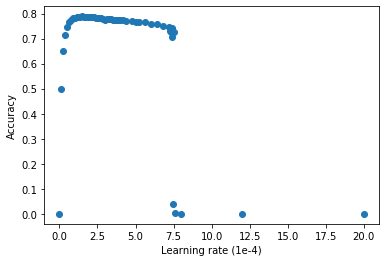

In [5]:
# Create a scatter plot of the values
from matplotlib.pyplot import plot, xlabel, xticks, ylabel
from numpy import array, argmax, linspace

def x_axis(x):
    t = linspace(0, round(x[-1], 4), 9)
    xticks(t, [f'{round(z*1e4,1)}' for z in t])

x = array([0] + list(df['lrate']))
y = array([0] + list(df['complete']))

x_axis(x)
xlabel('Learning rate (1e-4)')
ylabel('Accuracy')
plot(x, y, 'o')

m = argmax(y)
print(f'Maximum {y[m]} for a learning rate of {x[m]}.')

These points show a phase of rapid build-up to a slightly inclined plateau after which there is a sudden collapse of the accuracy. Let us investigate the top values to see if we can make an estimate of the optimal learning rate.

Optimal learning rate is around 1.53e-04.


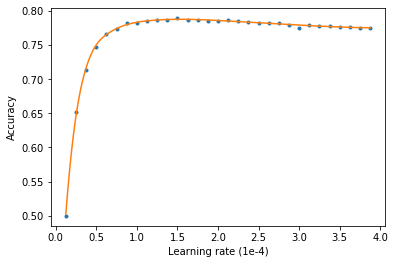

In [6]:
top = df[(df['complete'] > 1/3) & (df['lrate'] < 4e-4)]
xt = array(top['lrate'])
yt = array(top['complete'])

x_axis(xt)
xlabel('Learning rate (1e-4)')
ylabel('Accuracy')
plot(xt, yt, '.')

from numpy import linspace, var
from scipy.interpolate import UnivariateSpline
  
# Estimate the smoothing factor
s = var(yt) / len(yt)
spl = UnivariateSpline(xt, yt, s=s)

z = linspace(xt[0], xt[-1], num=len(xt)**2, endpoint=True)
plot (z, spl(z))

from scipy.optimize import fmin

xm = fmin(lambda xt: -spl(xt), xt[m], xtol=xt[m]*1e-4, disp=False)[0]
print(f'Optimal learning rate is around {xm:.2e}.')

# Now, let us do the same for the scores on the distinct words.

In [7]:
# Turn the objects in the 'distinct' column into proper lists
# and extract the maximum value from each of them.
x = array([0] + list(df['lrate']))
y = array([0] + list(df['distinct'].apply(eval).apply(max)))

Maximum 0.9620071518672392 for a learning rate of 0.00015.


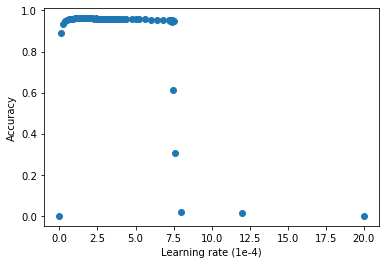

In [8]:
# Create a scatter plot of the values
x_axis(x)
xlabel('Learning rate (1e-4)')
ylabel('Accuracy')
plot(x, y, 'o')

m = argmax(y)
print(f'Maximum {y[m]} for a learning rate of {x[m]}.')

The graph shows the same kind of build-up and collapse as the one on the complete strings. Let us once more look at the top values to see if we can make an estimate of the optimal learning rate.

Optimal learning rate is around 1.54e-04.


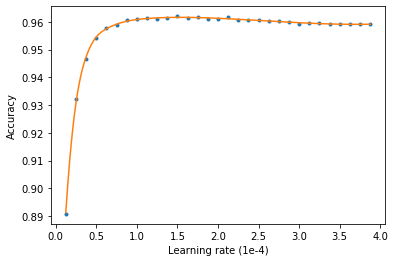

In [9]:
xt = array(top['lrate'])
yt = array(top['distinct'].apply(eval).apply(max))

x_axis(xt)
xlabel('Learning rate (1e-4)')
ylabel('Accuracy')
plot(xt, yt, '.')

# Estimate the smoothing factor
s = var(yt) / len(yt)
spl = UnivariateSpline(xt, yt, s=s)

z = linspace(xt[0], xt[-1], num=len(xt)**2, endpoint=True)
plot (z, spl(z))

xm = fmin(lambda xt: -spl(xt), xt[m], xtol=xt[m]*1e-4, disp=False)[0]
print(f'Optimal learning rate is around {xm:.2e}.')

# How does the learning rate influence the running time?

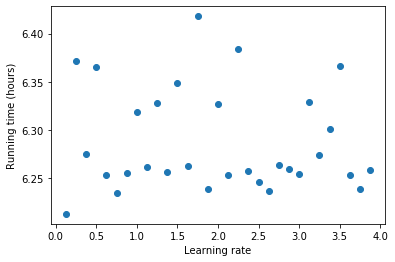

In [10]:
from datetime import datetime
from numpy import nan

def time(s):
    fmt = '%H:%M:%S'
    return datetime.strptime(s, fmt)

# We restrict ourselves to the top values.
running_times = list(top['times'].apply(eval))
dt = []

for t in running_times:
    dt.append(time(t[1]) - time(t[0]))

yt = array([t.seconds/3600 for t in dt])

x_axis(xt)
xlabel('Learning rate')
ylabel('Running time (hours)')
plot(xt, yt, 'o')

In [11]:
# Let us fit a linear function to see if there is a trend.
from scipy.optimize import curve_fit

def f(n,a,b):
    return a * n + b

fit = curve_fit(f, xt, yt)
[a,b] = fit[0]

Running time is 6h18m plus -16s per learning rate / 1e-4


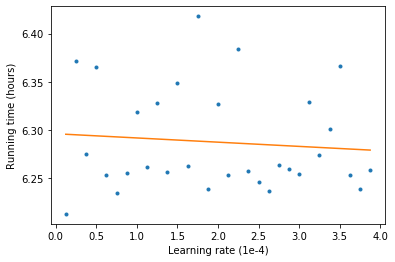

In [12]:
from numpy import vectorize

x_axis(xt)
xlabel('Learning rate (1e-4)')
ylabel('Running time (hours)')
plot(xt, yt, '.')
plot(xt, vectorize(f)(xt,a,b))

from math import modf

m, h = modf(b)
bstr = f'{int(h)}h{round(60*m)}m'
astr = f'{int(round(3600*a*1e-4, 0))}s'
print(f'Running time is {bstr} plus {astr} per learning rate / 1e-4')